<a href="https://colab.research.google.com/github/DeimosRecan/SiamiseNetworksInFacerRec/blob/main/SiamiseNetworksInFaceRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [15]:
# Вспомогательные функции
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [16]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #Нужно, чтобы около 50% изображений находились в одном классе
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Искать, пока не будет найдено изображение из того же класса
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Искать, пока не будет найдено изображение из другого класса
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        # Возвращаем преобразованные изображения
        # и Label(принадлежат к одному классу или нет).
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [18]:
# Загружаем датасет для обучения
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [19]:
# Изменяем размер изображений и преобразуем их в тензоры
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Инициализируем нейронную сеть
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

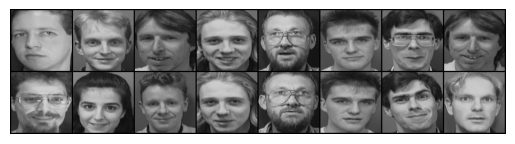

[1. 1. 1. 0. 0. 0. 0. 1.]


In [20]:
# Создаем загрузчик данных для простой визуализации
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Извлекаем один батч для примера
example_batch = next(iter(vis_dataloader))

# Пример партии данных представляет собой список,
# содержащий 2x8 изображений для индексов 0 и 1, а также Label.
# Если Label равна 1, это означает, на изображениях разные люди,
# и если равна 0 - наоборот
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [21]:
#Создаем сиамскую нейронную сеть
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Настройка последовательности слоев CNN
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Настройка полносвязных слоев.
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # Эта функция будет вызываться для обоих изображений
        # Ее выход используется для определения сходства
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # В этой функции мы передаем оба изображения
        # и получаем два вектора
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [22]:
# Определяем функцию контрастной потери
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Вычисляем евклидово расстояние и контрастную потерю
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [23]:
# Загружаем датасет для обучения
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [24]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.433638095855713

Epoch number 1
 Current loss 0.8485875129699707

Epoch number 2
 Current loss 0.9425579309463501

Epoch number 3
 Current loss 0.929114043712616

Epoch number 4
 Current loss 0.8067271113395691

Epoch number 5
 Current loss 0.7159546613693237

Epoch number 6
 Current loss 0.7743392586708069

Epoch number 7
 Current loss 0.8262749314308167

Epoch number 8
 Current loss 0.6618919372558594

Epoch number 9
 Current loss 0.7874290347099304

Epoch number 10
 Current loss 0.5844355821609497

Epoch number 11
 Current loss 0.45409971475601196

Epoch number 12
 Current loss 0.779838502407074

Epoch number 13
 Current loss 0.7243407964706421

Epoch number 14
 Current loss 0.4972893297672272

Epoch number 15
 Current loss 0.6769461631774902

Epoch number 16
 Current loss 0.5117024183273315

Epoch number 17
 Current loss 0.776562511920929

Epoch number 18
 Current loss 0.4637300372123718

Epoch number 19
 Current loss 0.33973896503448486

Epoch number

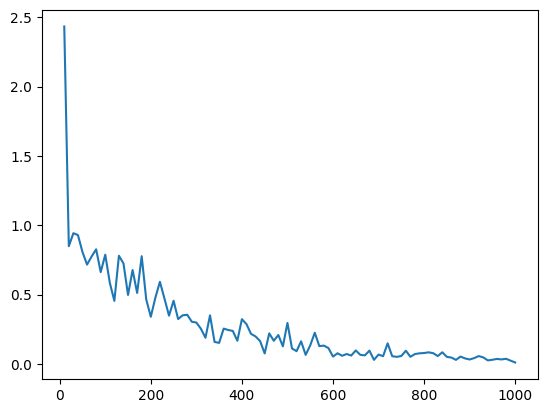

In [25]:
counter = []
loss_history = []
iteration_number= 0

# Итерируем по эпохам
for epoch in range(100):

    # Итерируем по партиям
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Отправляем изображения и метки на CUDA.
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Передаем два изображения в нейронную сеть и получаем два выхода
        output1, output2 = net(img0, img1)

        # Передаем выходы и метку в функцию потери
        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward()

        optimizer.step()

        # Каждые 10 партий выводим значение функции потери
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

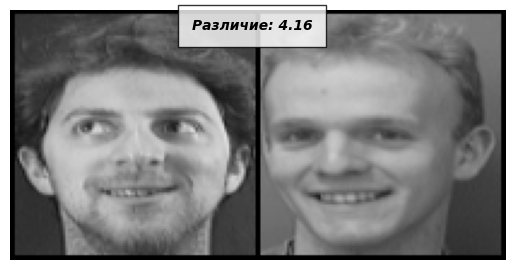

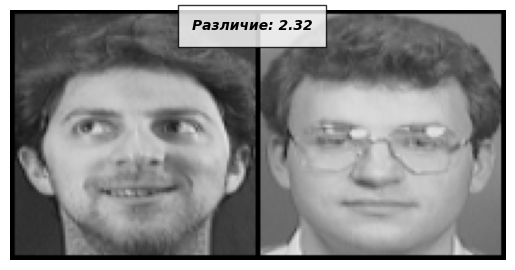

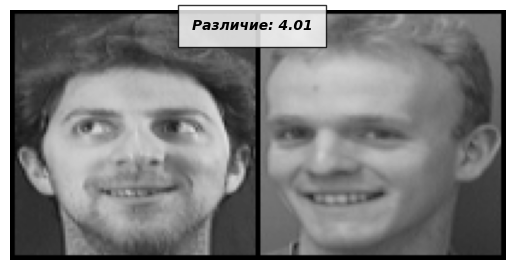

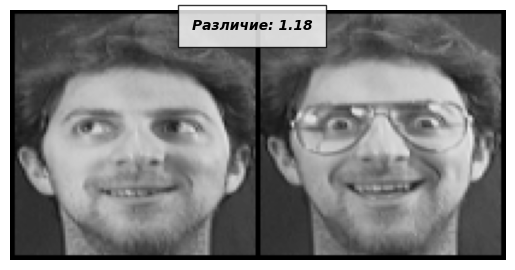

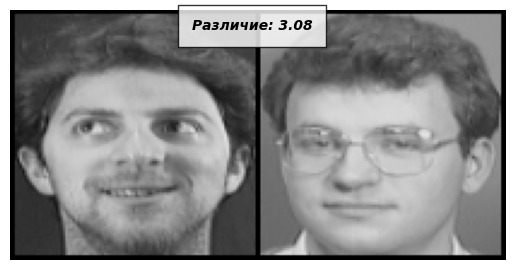

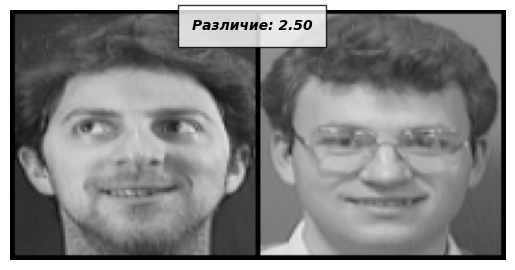

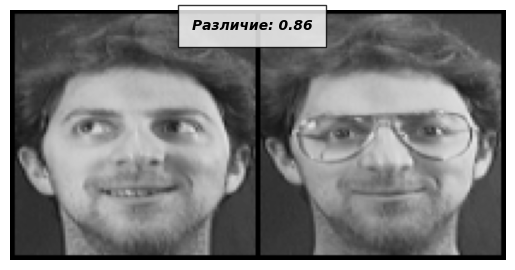

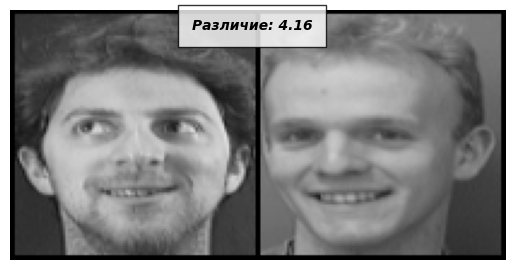

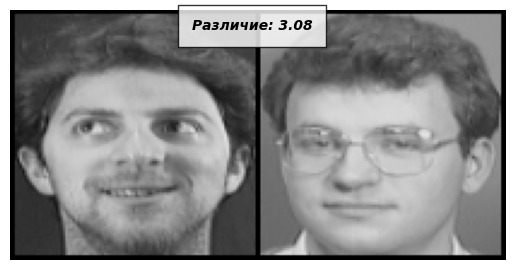

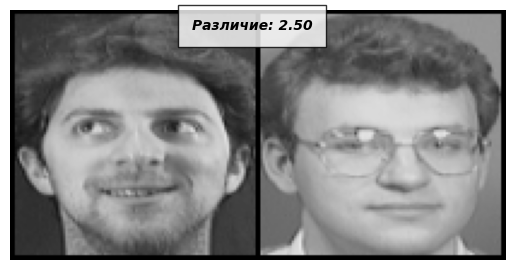

In [26]:
# Определяем тестовый датасет и загружаем его в SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Выбираем 1 фотографию, которую будем сравнивать
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Выбираем 10 изображений и сравниваем их с первой(x0)
    _, x1, label2 = next(dataiter)

    # Объединение 2 фотографий в одну
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Различие: {euclidean_distance.item():.2f}')

In [27]:
!pip install jupyter-dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.4 MB/s eta 0:00:00


In [28]:
#net = SiameseNetwork().cuda()
#net.state_dict()
#torch.save(net.state_dict(),'siamese_network.pt')

In [29]:
from jupyter_dash import JupyterDash
import dash
from dash.dependencies import Input, Output
import dash_html_components as html
import dash_core_components as dcc
import os

app = JupyterDash(__name__)

# Находим тестовый датасет и загружаем его в SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Макет страницы
app.layout = html.Div([
    html.H1('Нажмите Compare, чтобы сравнить изображение из датасета с другими'),
    html.Br(),
    html.Button("Compare", id="compare_button"),
    html.Br(),
    html.Div(id="image_output")
])

# Реакция на нажатие кнопки
@app.callback(
    Output("image_output", "children"),
    [Input("compare_button", "n_clicks")]
)
def display_image_dissimilarity(n_clicks):
    if n_clicks:
      output = []
      # Берем изображение которое будем сравнивать с другими
      dataiter = iter(test_dataloader)
      x0, _, _ = next(dataiter)

      for i in range(10):
        # итерируем 10 изображений и сравниваем с первым (x0)
        _, x1, label2 = next(dataiter)

        # Объединение 2 изображений в одно
        concatenated = torch.cat((x0, x1), 0)
        Grid = torchvision.utils.make_grid(concatenated)
        img = torchvision.transforms.ToPILImage()(Grid)

        output1, output2 = net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        output.append(html.Br())
        output.append(html.Br())
        output.append(f'Различие: {euclidean_distance.item():.2f}')
        output.append(html.Br())
        output.append(html.Img(src=img))

      return output

# Запуск приложения
app.run_server(port=5001)

Dash app running on:


<ipython-input-29-575f30136f0a>:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
<ipython-input-29-575f30136f0a>:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/usr/local/lib/python3.10/dist-packages/dash/dash.py:550: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>